In [1]:
import pandas as pd
import numpy as np
import requests
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.style.use("seaborn")

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Defining Features and Classifier

In [2]:
df_common = pd.read_csv("Trees_common.csv", index_col=False)

In [3]:
df_common.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,0,29


In [4]:
X = df_common.drop("Cover_Type",axis=1)
y = df_common["Cover_Type"]

In [5]:
#Splitting the set (test = 0.3) in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y, random_state=4444)

In [6]:
#scaling the features
sca = StandardScaler()
X_train_sca = sca.fit_transform(X_train)
X_test_sca = sca.transform(X_test);

In [7]:
# Scores for the test sets for an estimator
def alg_class(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_pred,y_test)
    rec = recall_score(y_pred,y_test)
    prec = precision_score(y_pred,y_test)
    f1 = f1_score(y_pred,y_test)
    
    return acc, rec, prec, f1
    #return ("Accuracy: " + str(acc)), ("Recall: " + str(rec)), ("Precision: " + str(prec)), ("F1: " + str(f1))

In [8]:
def plot_scores(k, acc_, rec_, prec_, f1_):
    fig, axes = plt.subplots(1, 4, figsize=(30,6))
    axes[0].plot(k,acc_)
    axes[0].set_xlabel("C")
    axes[0].set_ylabel("Accuracy")

    axes[1].plot(k,rec_)
    axes[1].set_xlabel("C")
    axes[1].set_ylabel("Recall")

    axes[2].plot(k,prec_)
    axes[2].set_xlabel("C")
    axes[2].set_ylabel("Precision")

    axes[3].plot(k,f1_)
    axes[3].set_xlabel("C")
    axes[3].set_ylabel("F1")


In [23]:
# Trying with logistic regression different regularization constants
acc_ =[]
rec_ =[]
prec_ =[]
f1_ =[]
k_ = []
C_ = [0.01, 0.1]
for item in C_:
    k_.append(item) 
    acc, rec, prec, f1 = alg_class(LogisticRegression(C=item), X_train_sca, y_train, X_test_sca, y_test)
    acc_.append(acc)
    rec_.append(rec)
    prec_.append(prec)
    f1_.append(f1)

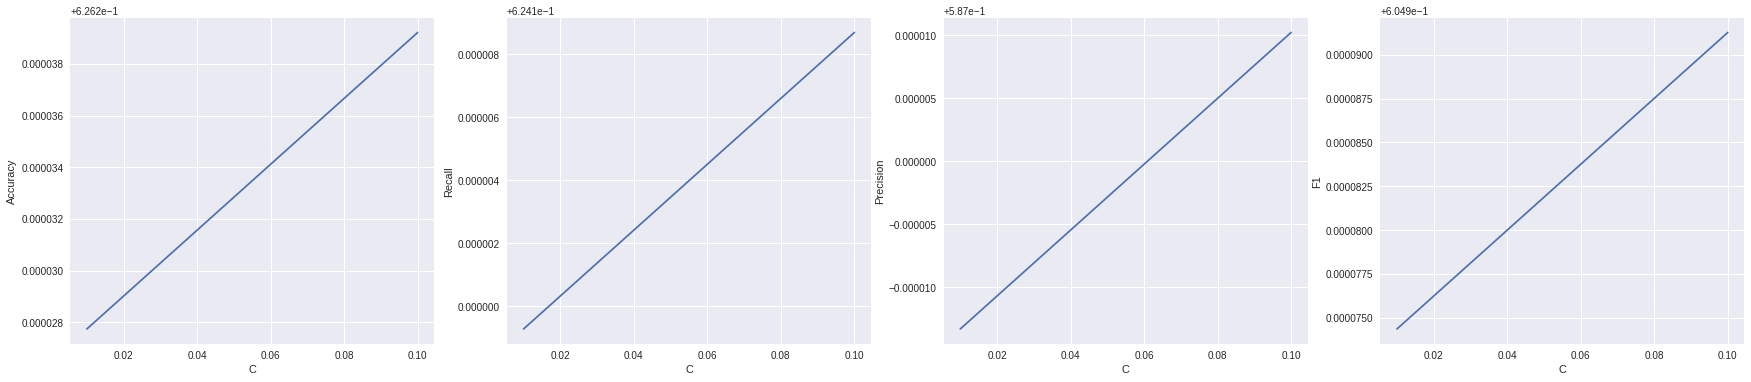

In [24]:
plot_scores(k_, acc_, rec_, prec_, f1_)

In [27]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [35]:
alg_class(LogisticRegression(C=0.1,penalty='l1'), X_train_sca, y_train, X_test_sca, y_test)

(0.6261015237745547,
 0.6240268355571131,
 0.5866101894340511,
 0.6047403022731132)

In [38]:
#Now with cross validation and polynomial features
def grid_estimator(estimator, param_grid, X_train, y_train, X_test, y_test, cv=5):
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, n_jobs=1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    print("Accuracy training: " + str(grid.best_score_))
    print("Accuracy test: " + str(accuracy_score(y_pred,y_test)))
    print("Recall test: " + str(recall_score(y_pred,y_test)))
    print("Precision test: " + str(precision_score(y_pred,y_test)))
    print("F1 score test: " + str(f1_score(y_pred,y_test)))
    print(grid.best_estimator_)

In [39]:
param_grid = {'C': [0.01,0.1,1,10,100], 'penalty': ['l1','l2']}
grid_estimator(LogisticRegression(), param_grid, X_train_sca, y_train, X_test_sca, y_test)

Accuracy training: 0.6274255731384679
Accuracy test: 0.6262392142463742
Recall test: 0.6241086842302784
Precision test: 0.5870102364984116
F1 score test: 0.6049912689173457
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [ ]:
param_grid = {'C': [0.01,0.1,1,10,100], 'penalty': ['l1','l2']}
#param_grid = {}
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_sca)
X_test_poly = poly.fit_transform(X_test_sca)
grid_estimator(LogisticRegression(), param_grid, X_train_poly, y_train, X_test_poly, y_test)

In [ ]:
param_grid = {'C': [0.01,0.1,1,10,100], 'penalty': ['l1','l2']}
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train_sca)
X_test_poly = poly.fit_transform(X_test_sca)
grid_estimator(LogisticRegression(), param_grid, X_train_poly, y_train, X_test_poly, y_test)

In [ ]:
param_grid = {'C': [0.01,0.1,1,10,100], 'penalty': ['l1','l2']}
poly = PolynomialFeatures(4)
X_train_poly = poly.fit_transform(X_train_sca)
X_test_poly = poly.fit_transform(X_test_sca)
grid_estimator(LogisticRegression(), param_grid, X_train_poly, y_train, X_test_poly, y_test)